## Flax.nnx API

The main difference between the Flaxnnx.Module and other Module systems in Flax Linen or Haiku is that in NNX everything is explicit. This means, among other things, that the nnx.Module itself holds the state (such as parameters) directly, the PRNG state is threaded by the user, and all shape information must be provided on initialization (no shape inference).

**NOTE: that the inner values of nnx.Variables can be accessed using the value property, but for convenience they implement all numeric operators and can be used directly in arithmetic expressions (as shown in the code above).**

Since nnx.Modules hold their own state methods, you can call them directly without the need for a separate apply method. This can be very convenient for debugging, allowing you to directly inspect the entire structure of the model.

In [8]:
from flax import nnx
import jax
import jax.numpy as jnp

class Linear(nnx.Module):
    def __init__(self,fin:int,fout:int,rngs:nnx.Rngs):
        super().__init__()
        key=rngs.params()
        # nnx.Param ==> nn.Parameter of torch
        self.W=nnx.Param(jax.random.uniform(key,(fin,fout)))
        self.b=nnx.Param(jnp.zeros(fout))

    def __call__(self, x:jax.Array):
        return x@self.W + self.b

# No need to apply() in-order to init weights
lin=Linear(3,10,nnx.Rngs(0))
out=lin(jax.random.normal(jax.random.key(42),(3,3)))

print(out.shape)

nnx.display(lin)

(3, 10)
Linear(
  W=Param(
    value=Array(shape=(3, 10), dtype=float32)
  ),
  b=Param(
    value=Array(shape=(10,), dtype=float32)
  )
)


### Stateful Computation:
Implementing layers, such as **nnx.BatchNorm**, requires performing state updates during a forward pass. In Flax NNX, you just need to create a nnx.Variable and update its .value during the forward pass.

In [9]:
class MyBatchNorm(nnx.Module):
    def __init__(self,in_features,rngs:nnx.Rngs,eps=1e-5):
        super().__init__()
        gamma_key,beta_key=jax.random.split(rngs.params(),2)
        self.eps=eps
        self.running_mean=jnp.zeros(in_features)
        self.running_std=jnp.ones(in_features)

        self.gamma=nnx.Param(jax.random.uniform(gamma_key,(in_features,)))
        self.beta=nnx.Param(jax.random.uniform(beta_key,(in_features,)))
        
    def __call__(self,x:jax.Array,is_training=True):
        if is_training:
            mean=jnp.mean(x,axis=0)
            std=jnp.std(x,axis=0)
            # use Variable.value whenever we want to access the value
            self.running_mean=self.eps*self.running_mean+(1-self.eps)*mean
            self.running_std=self.eps*self.running_std+(1-self.eps)*std
        else:
            mean=self.running_mean
            std=self.running_std
            
        return (x-mean)/std*self.gamma+self.beta
    
bn=MyBatchNorm(3,nnx.Rngs(0))
out=bn(jax.random.normal(jax.random.key(42),(3,3)))

print(out.shape)
nnx.display(bn)

(3, 3)
MyBatchNorm(
  eps=1e-05,
  running_mean=Array(shape=(3,), dtype=float32),
  running_std=Array(shape=(3,), dtype=float32),
  gamma=Param(
    value=Array(shape=(3,), dtype=float32)
  ),
  beta=Param(
    value=Array(shape=(3,), dtype=float32)
  )
)


In [10]:
class CustomDense(nnx.Module):
    def __init__(self,fin:int,fout:int,rngs:nnx.Rngs,dropout=0.2):
        super().__init__()
        self.dense=[
            nnx.Linear(fin,fout,rngs=rngs),
            nnx.relu,
            nnx.BatchNorm(fout,rngs=rngs),
            nnx.Dropout(dropout,rngs=rngs)
        ]

    def __call__(self,x:jax.Array,is_training=True):
        for layer in self.dense:
            if isinstance(layer,nnx.BatchNorm):
                x=layer(x,use_running_average=not is_training)
            elif isinstance(layer,nnx.Dropout):
                x=layer(x,deterministic=not is_training)
            else:
                x=layer(x)
        return x
   


class MLP(nnx.Module):
    def __init__(self,layer_dims:list,rngs:nnx.Rngs):
        super().__init__()
        self.layers=[
            CustomDense(in_dim,out_dim,rngs=rngs) for in_dim,out_dim in zip(layer_dims[:-2],layer_dims[1:-1])
        ]
        self.layers.append(nnx.Linear(layer_dims[-2],layer_dims[-1],rngs=rngs))

    def __call__(self,x:jax.Array,is_training=True):
        for layer in self.layers:
            if isinstance(layer,nnx.BatchNorm):
                x=layer(x,use_running_average=not is_training)
            elif isinstance(layer,nnx.Dropout):
                x=layer(x,deterministic=not is_training)
            else:
                x=layer(x)
        return x
    
    

mlp=MLP([3,16,32,16,10],nnx.Rngs(0))
out=mlp(jax.random.normal(jax.random.key(42),(3,3)))

print(out.shape)
nnx.display(mlp)

(3, 10)
MLP(
  layers=[CustomDense(
    dense=[Linear(
      kernel=Param(
        value=Array(shape=(3, 16), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(16,), dtype=float32)
      ),
      in_features=3,
      out_features=16,
      use_bias=True,
      dtype=None,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      kernel_init=<function variance_scaling.<locals>.init at 0x000002189FE6AAC0>,
      bias_init=<function zeros at 0x000002189F405300>,
      dot_general=<function dot_general at 0x000002189EF111C0>
    ), <jax._src.custom_derivatives.custom_jvp object at 0x000002189F4B6A80>, BatchNorm(
      mean=BatchStat(
        value=Array(shape=(16,), dtype=float32)
      ),
      var=BatchStat(
        value=Array(shape=(16,), dtype=float32)
      ),
      scale=Param(
        value=Array(shape=(16,), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(16,), dtype=float32)
      ),
      num_features=16,
      use_running

#### **Better way to handle training and evaluating mode: __Context Manager__**

In [11]:
from contextlib import contextmanager

@contextmanager
def eval_mode(model:nnx.Module):
    """
    Context manager to switch all layers in the list to evaluation mode,inplace
    """ 
    def switch_mode(module:nnx.Module):
        if isinstance(module,nnx.BatchNorm):
            module.use_running_average=not module.use_running_average
        elif isinstance(module,nnx.Dropout):
            module.deterministic=not module.deterministic
    
    try:
        for path,module in model.iter_modules():
            switch_mode(module)
        yield
    finally:
        for path,module in model.iter_modules():
            switch_mode(module)

# =================================================================================


class CustomDense(nnx.Module):
    def __init__(self,fin:int,fout:int,rngs:nnx.Rngs,dropout=0.2):
        super().__init__()
        __layers=[
            nnx.Linear(fin,fout,rngs=rngs),
            nnx.relu,
            nnx.BatchNorm(fout,rngs=rngs),
            nnx.Dropout(dropout,rngs=rngs)
        ]

        self.dense=nnx.Sequential(*__layers)

    def __call__(self,x:jax.Array,is_training=True):
        if not is_training:
            with eval_mode(self):
                return self.dense(x)
        return self.dense(x)
    


class MLP(nnx.Module):
    def __init__(self,layer_dims:list,rngs:nnx.Rngs):
        super().__init__()
        __layers=[
            CustomDense(in_dim,out_dim,rngs=rngs) for in_dim,out_dim in zip(layer_dims[:-2],layer_dims[1:-1])
        ]
        __layers.append(nnx.Linear(layer_dims[-2],layer_dims[-1],rngs=rngs))
        self.mlp=nnx.Sequential(*__layers)

    def __call__(self,x:jax.Array,is_training=True):
        if not is_training:
            with eval_mode(self):
                return self.mlp(x)  
        return self.mlp(x)
    

mlp=MLP([3,16,16,10],nnx.Rngs(0))
out=mlp(jax.random.normal(jax.random.key(42),(3,3)))

print(out.shape)
nnx.display(mlp)

print("\n","#"*50,"\n")


with eval_mode(mlp):
    # u can check all layers that maintain states have those parameters altered
    nnx.display(mlp)

(3, 10)
MLP(
  mlp=Sequential(
    layers=[CustomDense(
      dense=Sequential(
        layers=[Linear(
          kernel=Param(
            value=Array(shape=(3, 16), dtype=float32)
          ),
          bias=Param(
            value=Array(shape=(16,), dtype=float32)
          ),
          in_features=3,
          out_features=16,
          use_bias=True,
          dtype=None,
          param_dtype=<class 'jax.numpy.float32'>,
          precision=None,
          kernel_init=<function variance_scaling.<locals>.init at 0x000002189FE6AAC0>,
          bias_init=<function zeros at 0x000002189F405300>,
          dot_general=<function dot_general at 0x000002189EF111C0>
        ), <jax._src.custom_derivatives.custom_jvp object at 0x000002189F4B6A80>, BatchNorm(
          mean=BatchStat(
            value=Array(shape=(16,), dtype=float32)
          ),
          var=BatchStat(
            value=Array(shape=(16,), dtype=float32)
          ),
          scale=Param(
            value=Array(shape=(

### Model Surgery:
Flax nnx.Modules are mutable by default. This means that their structure can be changed at any time, which makes model surgery quite easy, as any sub-Module attribute can be replaced with anything else, such as new Modules, existing shared Modules, Modules of different types, and so on. Moreover, nnx.Variables can also be modified or replaced/shared.nnx.Module are mutable by default.

In [12]:
class MLP(nnx.Module):
  def __init__(self, din: int, dmid: int, dout: int,  rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(din, dmid, rngs=rngs)
    self.dropout = nnx.Dropout(rate=0.1, rngs=rngs)
    self.bn = nnx.BatchNorm(dmid, rngs=rngs)
    self.linear2 = nnx.Linear(dmid, dout, rngs=rngs)

  def __call__(self, x: jax.Array):
    x = nnx.gelu(self.dropout(self.bn(self.linear1(x))))
    return self.linear2(x)

model = MLP(2, 16, 5, rngs=nnx.Rngs(0))

nnx.display(model)
print("\n","#"*40,"\n")


# Adding lora adapter to the model

class LoraLinear(nnx.Module):
  def __init__(self, linear: nnx.Linear, rank: int, rngs: nnx.Rngs):
    self.linear = linear
    self.A = nnx.Param(jax.random.normal(rngs(), (linear.in_features, rank)))
    self.B = nnx.Param(jax.random.normal(rngs(), (rank, linear.out_features)))

  def __call__(self, x: jax.Array):
    return self.linear(x) + x @ self.A @ self.B

rngs = nnx.Rngs(0)
model = MLP(2, 32, 5, rngs=rngs)

# Model surgery
model.linear1 = LoraLinear(model.linear1, 4, rngs=rngs)
model.linear2 = LoraLinear(model.linear2, 4, rngs=rngs)

y = model(x=jnp.ones((3, 2)))

nnx.display(model)

MLP(
  linear1=Linear(
    kernel=Param(
      value=Array(shape=(2, 16), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(16,), dtype=float32)
    ),
    in_features=2,
    out_features=16,
    use_bias=True,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x000002189FE6AAC0>,
    bias_init=<function zeros at 0x000002189F405300>,
    dot_general=<function dot_general at 0x000002189EF111C0>
  ),
  dropout=Dropout(rate=0.1, broadcast_dims=(), deterministic=False, rng_collection='dropout', rngs=Rngs(
    default=RngStream(
      key=RngKey(
        value=Array((), dtype=key<fry>) overlaying:
        [0 0],
        tag='default'
      ),
      count=RngCount(
        value=Array(6, dtype=uint32),
        tag='default'
      )
    )
  )),
  bn=BatchNorm(
    mean=BatchStat(
      value=Array(shape=(16,), dtype=float32)
    ),
    var=BatchStat(
      value=Array(shape=(16,), dtype=flo

### Flax Tranformations

Extend JAX transforms to support nnx.Modules and other objects. They serve as supersets of their equivalent JAX counterparts with the addition of being aware of the object’s state and providing additional APIs to transform it.

for eg: **nnx.value_and_grad** or **nnx.Optimizer.update** (to update model params) or **nnx.jit** (this has performance overhead for small models) or **nnx.Scan** (scan for nnx.Module layers in your model and stack them to pass x one after) etc, but u can even use the jax.transform as they too are compatible with nnx API. 


### scan, merge & update

* **nnx.split(model;nnx.Module) -> [nnx.GradphDef,nnx.State]** : decompe nnx.Module into GraphDef and State

    1. **nnx.State** is a Mapping from strings to nnx.Variables or nested States.

    2. **nnx.GraphDef** contains all the static information needed to reconstruct a nnx.Module graph, it is analogous to JAX’s PyTreeDef.
 nnx.State


* **nnx.merge(graphdef:nnx.GraphDef,state:nnx.State) -> [nnx.Module]** : merge graphdef and stae to recreate the nnx.Module object.

* __nnx.update(node:nnx.Module,*states:nnx.State)__ can update an object in place with the content of a given nnx.State.

### Training a simple MLP

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import jax
import jax.numpy as jnp

from flax import nnx
from optax import sgd


In [14]:
X,y=load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(120, 4) (120,) (30, 4) (30,)


In [15]:
from contextlib import contextmanager

@contextmanager
def eval_mode(model:nnx.Module):
    """
    Context manager to switch all layers in the list to evaluation mode,inplace
    """ 
    def switch_mode(module:nnx.Module):
        if isinstance(module,nnx.BatchNorm):
            module.use_running_average=not module.use_running_average
        elif isinstance(module,nnx.Dropout):
            module.deterministic=not module.deterministic
    
    try:
        for path,module in model.iter_modules():
            switch_mode(module)
        yield
    finally:
        for path,module in model.iter_modules():
            switch_mode(module)


# =====================================================================================


class CustomDense(nnx.Module):
    def __init__(self,fin:int,fout:int,rngs:nnx.Rngs,dropout=0.2):
        super().__init__()

        self.dense=nnx.Sequential(
            nnx.Linear(fin,fout,rngs=rngs),
            nnx.relu,
            nnx.BatchNorm(fout,rngs=rngs),
            nnx.Dropout(dropout,rngs=rngs)
        )

    def __call__(self,x:jax.Array,is_training=True):
        if not is_training:
            with eval_mode(self):
                return self.dense(x)
        return self.dense(x)
    
   
   
    

class MLP(nnx.Module):
    def __init__(self,layer_dims:list,rngs:nnx.Rngs):
        super().__init__()
        self.mlp=nnx.Sequential(
            *[ CustomDense(in_dim,out_dim,rngs=rngs) for in_dim,out_dim in zip(layer_dims[:-2],layer_dims[1:-1]) ],
            nnx.Linear(layer_dims[-2],layer_dims[-1],rngs=rngs)
        )

    def __call__(self,x:jax.Array,is_training=True):
        if not is_training:
            with eval_mode(self):
                return self.mlp(x)  
        return self.mlp(x)
    
    

mlp=MLP([X_train.shape[-1],16,16,3],nnx.Rngs(0))
out=mlp(jax.random.normal(jax.random.key(42),(4,4)))

print(out.shape)
nnx.display(mlp)

(4, 3)
MLP(
  mlp=Sequential(
    layers=[CustomDense(
      dense=Sequential(
        layers=[Linear(
          kernel=Param(
            value=Array(shape=(4, 16), dtype=float32)
          ),
          bias=Param(
            value=Array(shape=(16,), dtype=float32)
          ),
          in_features=4,
          out_features=16,
          use_bias=True,
          dtype=None,
          param_dtype=<class 'jax.numpy.float32'>,
          precision=None,
          kernel_init=<function variance_scaling.<locals>.init at 0x000002189FE6AAC0>,
          bias_init=<function zeros at 0x000002189F405300>,
          dot_general=<function dot_general at 0x000002189EF111C0>
        ), <jax._src.custom_derivatives.custom_jvp object at 0x000002189F4B6A80>, BatchNorm(
          mean=BatchStat(
            value=Array(shape=(16,), dtype=float32)
          ),
          var=BatchStat(
            value=Array(shape=(16,), dtype=float32)
          ),
          scale=Param(
            value=Array(shape=(1

In [16]:
import math
from matplotlib.pyplot import hist
import optax
from scipy import optimize 

metrics=nnx.MultiMetric(
    accuracy=nnx.metrics.Accuracy(),
    # metrics.fn('identifier')-> identifier is the keyword arg the metric.update() will use to dereive new val  
    loss=nnx.metrics.Average('loss')
)



@nnx.jit
def loss_fn(model:MLP,x:jax.Array,y:jax.Array):
    logits=model(x)
    loss=optax.softmax_cross_entropy_with_integer_labels(logits,y).mean()
    return loss,logits

@nnx.jit
def step(model:MLP,x:jax.Array,y:jax.Array):
    return nnx.value_and_grad(loss_fn,has_aux=True)(model,x,y)
    

BATCH_SIZE=32
LEARNING_RATE=0.02
EPOCHS=75

# nnx.Optimizer(model:nnx.Module,tx:optax,wrt:nnx.Module)-> wrt decide the Variables wrt which the optimizer will be applied
optimizer=nnx.Optimizer(mlp,optax.sgd(LEARNING_RATE),wrt=nnx.Param)

history={'train_loss':[],'val_loss':[],'train_accuracy':[],'val_accuracy':[]}

for epoch in range(EPOCHS):
    n=math.ceil(X_train.shape[0]/BATCH_SIZE)
    for i in range(n):
        batch_X=X_train[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        batch_y=y_train[i*BATCH_SIZE:(i+1)*BATCH_SIZE]

        (loss,logits),grads=step(mlp,batch_X,batch_y)
        metrics.update(logits=logits,labels=batch_y,loss=loss)
        
        # optimizer step
        optimizer.update(grads=grads)
    
    # log metrics
    for metric,value in metrics.compute().items():
        history[f'train_{metric}'].append(value)
    metrics.reset()


    # validation loop
    with eval_mode(mlp.layers()):
        n=math.ceil(X_test.shape[0]/BATCH_SIZE)
        for i in range(n):
            batch_X=X_test[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
            batch_y=y_test[i*BATCH_SIZE:(i+1)*BATCH_SIZE]

            (loss,logits),grads=step(mlp,batch_X,batch_y)
            metrics.update(logits=logits,labels=batch_y,loss=loss)
        
        # log metrics
        for metric,value in metrics.compute().items():
            history[f'val_{metric}'].append(value)
        metrics.reset()

    if (epoch+1)%5==0:
        print(f'epoch:{epoch+1},train_loss:{history["train_loss"][-1]:.4f},train_acc:{history["train_accuracy"][-1]:.4f},val_loss:{history["val_loss"][-1]:.4f},val_acc:{history["val_accuracy"][-1]:.4f}\n')


epoch:5,train_loss:0.6390,train_acc:0.7583,val_loss:0.7760,val_acc:0.8333

epoch:10,train_loss:0.4941,train_acc:0.8083,val_loss:0.6394,val_acc:0.9000

epoch:15,train_loss:0.3391,train_acc:0.9333,val_loss:0.5426,val_acc:0.9000

epoch:20,train_loss:0.3094,train_acc:0.9250,val_loss:0.4603,val_acc:0.9000

epoch:25,train_loss:0.2899,train_acc:0.9250,val_loss:0.3916,val_acc:0.9333

epoch:30,train_loss:0.2545,train_acc:0.9167,val_loss:0.3342,val_acc:0.9333

epoch:35,train_loss:0.2511,train_acc:0.9083,val_loss:0.2783,val_acc:0.9667

epoch:40,train_loss:0.2264,train_acc:0.8833,val_loss:0.2382,val_acc:0.9667

epoch:45,train_loss:0.2036,train_acc:0.9583,val_loss:0.1970,val_acc:1.0000

epoch:50,train_loss:0.1728,train_acc:0.9500,val_loss:0.1636,val_acc:1.0000

epoch:55,train_loss:0.1886,train_acc:0.9333,val_loss:0.1357,val_acc:1.0000

epoch:60,train_loss:0.1656,train_acc:0.9333,val_loss:0.1147,val_acc:1.0000

epoch:65,train_loss:0.1509,train_acc:0.9417,val_loss:0.1010,val_acc:1.0000

epoch:70,trai

In [17]:
import matplotlib.pyplot as plt


def plot_history(history,metric,train_kwargs={},val_kwargs={}):
    plt.plot(history[f'train_{metric}'],label=f'train_{metric}',**train_kwargs)
    plt.plot(history[f'val_{metric}'],label=f'val_{metric}',**val_kwargs)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show

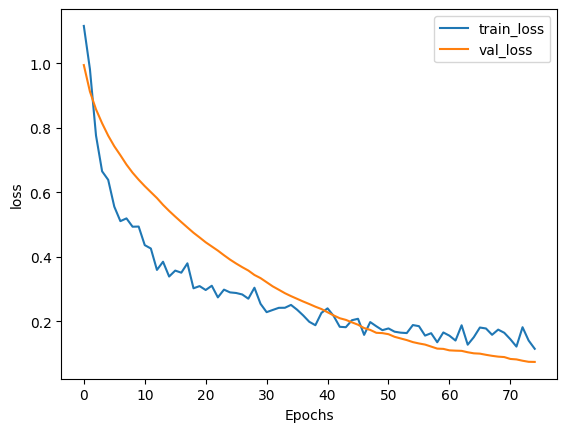

In [18]:
plot_history(history,'loss')

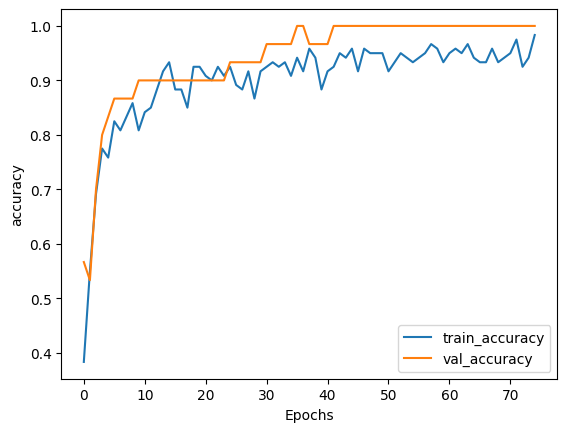

In [19]:
plot_history(history,'accuracy')

In [20]:
## TODO: GUIDES 'https://flax.readthedocs.io/en/latest/guides/transforms.html'